# Sklearn Interface Tutorial

This tutorial will walk you through using the sklearn style DAGRegressor and DAGClassifier models on two familiar datasets: Boston Housing and Breast Cancer.

**NOTE** `pytorch` is requred for this tutorial.

___
## DAGRegressor
This section demonstrates the performance of the DAGRegressor on a real-world dataset. The main things to note in this section are:

- The scale sensitivity of the algorithm

- Interpretability of nonlinear `.coef_`

### The Data: Boston Housing

The boston housing dataset is a classic benchmark regression task. The objective is to predict a set of house prices given a small set of features.

The meaning of the set of avaliable features is shown below.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
data = load_boston()
print(data["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Lets initially benchmark the performance of an `ElasticNetCV` fitted across the entire dataset.

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.700


### Linear DAGRegressor

The DAGRegressor has several parameters which can be used to better fit a more complicated noisy DAG:

- `alpha`: The l1 (lasso) regularisation parameter. Increasing this creates a sparser DAG.

- `beta`: The l2 (ridge) regularisation parameter.

It was decided to use `alpha` and `beta` rather than `alpha` and `l1_ratio` like in sklearn elasticnet to uncouple the parameters during optimisation.

There are several parameters which are also of interest which have good defaults, but we highlight here:

- `dependent_target`: This forces the target variable y to be only a child node. This is important for performance because in some cases `X -> y` is indistinguishable from `y -> X`. Enabling this (default enabled) ensures that the regressor performance at least matches linear regression. The trade-off is that the learned structure might be less accurate if y does cause other features.

- `enforce_dag`: This thresholds the learned structure model until the system is a DAG. This is useful for removing the small straggler connections which enables the DAG to be visualised easier. It does not impact performance, because the regressor still uses those connections under the hood.

MEAN R2: 0.706
CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.310045
AGE        0.000000
DIS       -0.225105
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT     -0.372530
dtype: float64


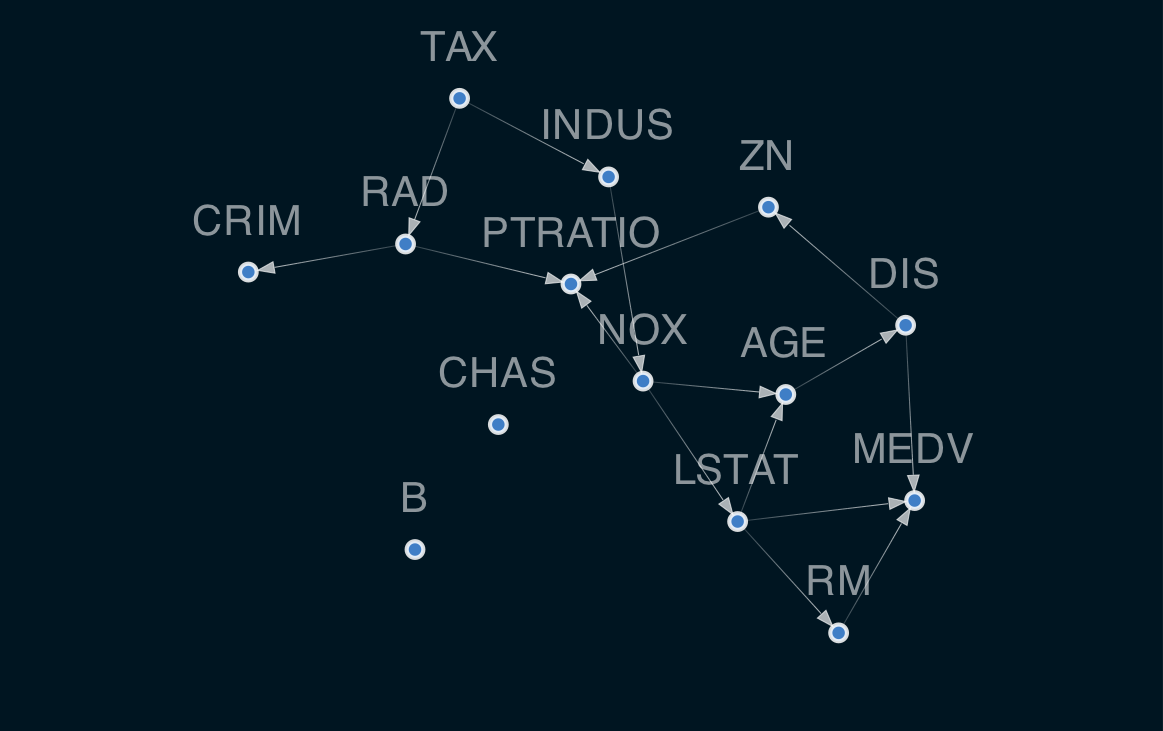

In [4]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure.pytorch import DAGRegressor
reg = DAGRegressor(
                alpha=0.1,
                beta=0.9,
                fit_intercept=True,
                hidden_layer_units=None,
                dependent_target=True,
                enforce_dag=True,
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

### NonLinear DAGRegressor

Specifying a nonlinear model is extremely simple, only a single parameter needs to be altered: `hidden_layer_units`

`hidden_layer_units` takes _any_ **iterable** of **integers**:

- The value specifies the number of perceptrons to use in each nonlinear MLP layer:

- The number of elements in the iterable determines the number of hidden layers.

The more layers and more perceptrons per layer, the more complicated the function which can be fit. The trade off is a greater tendency to overfit, and slower fitting.

A good default starting argument is ~\[5]. This is unlikely to overfit, and usually demonstrates immidiately whether the DAG has nonlinear components.

The setting of the `alpha` and `beta` parameters is very important.
Typically `beta` is more important than `alpha` when using nonlinear layers. This is because l2 is applied across all layers, whereas l1 is only applied to the first layer.
A good starting point is `~beta=0.5`.

**NOTE it is very important to scale your data!**

The nonlinear layers contain sigmoid nonlinearities which can become saturated with unscaled data. Also, unscaled data means that regularisation parameters do not impact weights across features equally.

For convnenience, setting `standardize=True` scales both the X and y data during fit. It also inverse transforms the y on predict similar to the sklearn `TransformedTargetRegressor`.

MEAN R2: 0.844


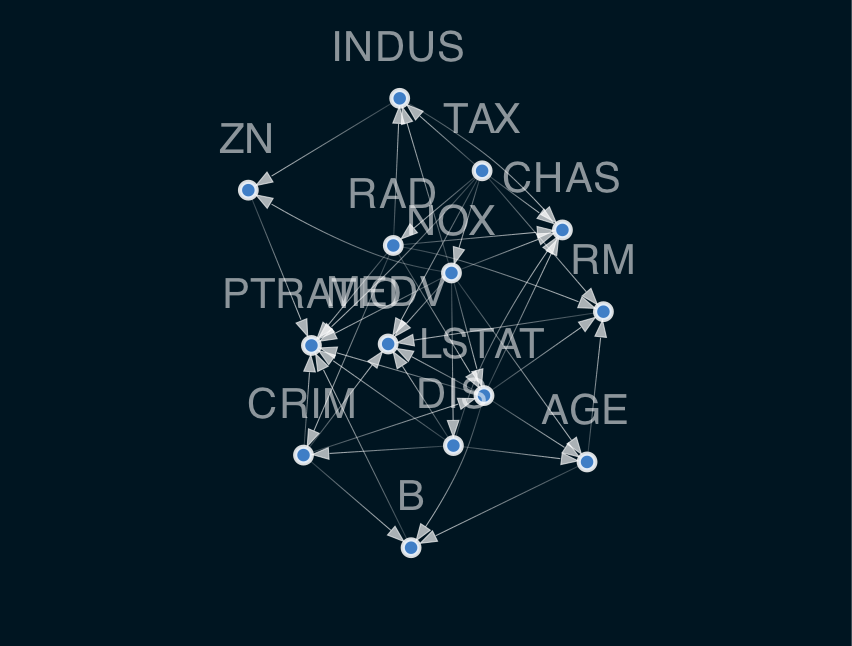

In [5]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure.pytorch import DAGRegressor
reg = DAGRegressor(threshold=0.0,
                    alpha=0.0,
                    beta=0.5,
                    fit_intercept=True,
                    hidden_layer_units=[5],
                    standardize=True,
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

#### Interpereting the Nonlinear DAG

For nonlinear analysis, understanding the impact of one feature on another is not as simple as taking the mean effect as in the linear case.
Instead, a combination of `reg.coef_` and `reg.feature_importances` should be used:

- `reg.coef_` provides the mean **directional** effect of all the features on the target. This gives average directional information, but can be misleading in terms of magnitude if the feature has a positive _and_ negative effect on the target.

- `reg.feature_importances_` provides the mean **magnitude** effect of the features on the target. These values will be _strictly larger_ than the `reg.coef_` because there are no cancellation effects due to sign differences. 

The magnitude difference between the `reg.coef_` and `reg.feature_importances_` values can give insight into the _degree of directional variability_ of the parameter:

- A large difference means that the parameter has **large positive and negative effects** on the target.

- A zero difference means that the parameter always has the same directional impact on the target.

MEAN R2: 0.844
MEAN EFFECT DIRECTIONAL:
CRIM      -0.304026
ZN        -0.091048
INDUS      0.032539
CHAS       0.021508
NOX       -0.209211
RM         0.336836
AGE       -0.150402
DIS       -0.456090
RAD        0.256074
TAX       -0.219712
PTRATIO   -0.107950
B          0.069724
LSTAT     -0.343452
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.305239
ZN         0.101236
INDUS      0.120835
CHAS       0.043857
NOX        0.209429
RM         0.362121
AGE        0.160438
DIS        0.456277
RAD        0.256279
TAX        0.232277
PTRATIO    0.119387
B          0.073945
LSTAT      0.347154
dtype: float64


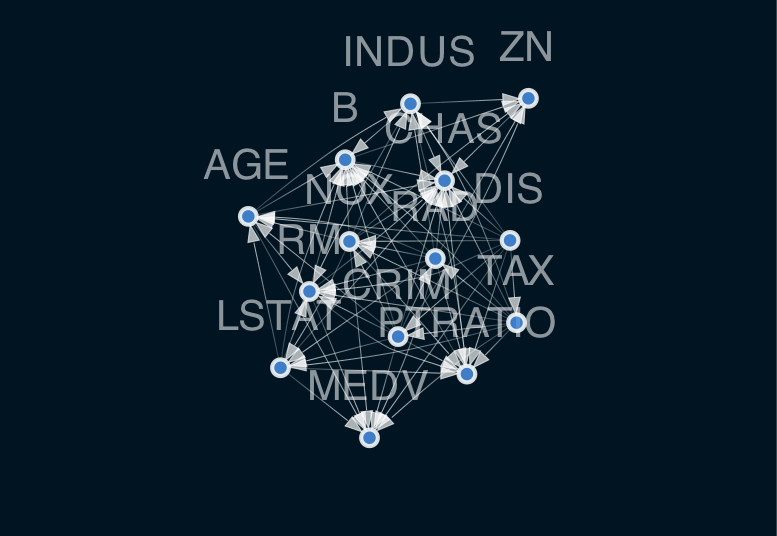

In [6]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure.pytorch import DAGRegressor
reg = DAGRegressor( alpha=0.0,
                    beta=1.0,
                    fit_intercept=True,
                    hidden_layer_units=[8, 8, 8],
                    standardize=True,
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

The `reg.get_edges_to_node` method allows for analysis of other edges in the graph easily.

Passing in `data="weight"` returns the mean effect magnitude of the variables on the requested node. It is equivalent to the `reg.feature_importances` return for the target node.

Passing in `data="mean_effect"` returns the mean directional effect.

Below is a good example of a large difference between the magnitude and directional effects:

- The feature RAD has overall a large effect on the presence of NOX.

- However, the _directional_ effect of this feature is highly variable, which leads the mean_effect to be an order of magnitude smaller than the mean effect magnitude!

In [7]:
vals = reg.get_edges_to_node("NOX", data="weight").copy()
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.285886
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.000000
AGE        0.000000
DIS        0.734959
RAD        0.334286
TAX        0.605885
PTRATIO    0.000000
B          0.000000
LSTAT      0.000000
dtype: float64

In [8]:
vals = reg.get_edges_to_node("NOX", data="mean_effect")
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.265320
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.000000
AGE        0.000000
DIS       -0.734052
RAD       -0.109260
TAX       -0.448117
PTRATIO    0.000000
B          0.000000
LSTAT      0.000000
dtype: float64

#### Dependent Target

Setting the `dependent_target=False` has an impact on performance as shown below, but can give better insight into the overall nonlinear structure of the data.

This is effectively the same as fitting causalnex on the data using from_pandas, but using the sklearn interface provides a set of useful convenience functions not present in the base causalnex implementation.

MEAN R2: 0.524
MEAN EFFECT DIRECTIONAL:
CRIM       0.000131
ZN         0.105332
INDUS     -0.146670
CHAS      -0.000312
NOX       -0.162881
RM         0.001096
AGE        0.028959
DIS       -0.261790
RAD        0.214047
TAX       -0.250295
PTRATIO    0.000126
B         -0.000349
LSTAT     -0.512397
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.000131
ZN         0.105332
INDUS      0.170616
CHAS       0.000312
NOX        0.162881
RM         0.001096
AGE        0.028959
DIS        0.261790
RAD        0.214047
TAX        0.250295
PTRATIO    0.000126
B          0.000349
LSTAT      0.512397
dtype: float64


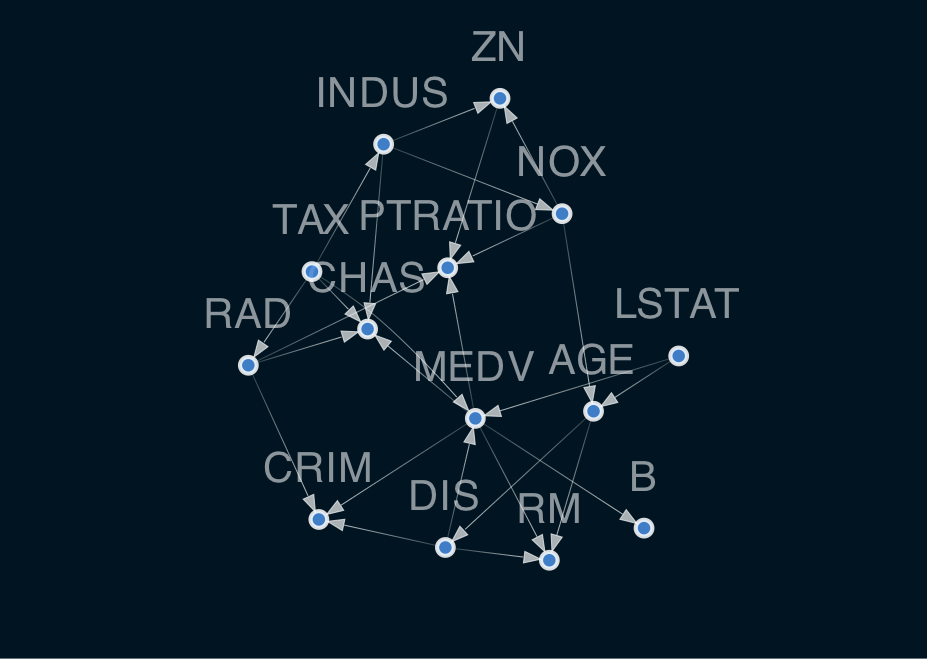

In [9]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure.pytorch import DAGRegressor
reg = DAGRegressor( alpha=0.0,
                    beta=1.0,
                    fit_intercept=True,
                    hidden_layer_units=[5],
                    standardize=True,
                    dependent_target=False,
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

___
## DAGClassifier
This section demonstrates the performance of the algorithm on a real-world dataset.

The interface is very similar to the DAGRegressor so key details should be found there.

### Binary Classifier
#### The Data: Breast Cancer

In [10]:
from sklearn.datasets import load_breast_cancer
print(load_breast_cancer(return_X_y=False)["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [11]:

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold
    scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
    print(f'MEAN Score: {np.mean(scores).mean():.3f}')

    X = pd.DataFrame(X, columns=names)
    y = pd.Series(y, name="NOT CANCER")
    clf.fit(X, y)
    for i in range(clf.coef_.shape[0]):
        print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
        print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))

MEAN Score: 0.944
MEAN EFFECT DIRECTIONAL CLASS 0:
worst radius               1.041636
mean radius                0.979513
mean texture               0.469473
texture error              0.390102
mean perimeter             0.260891
perimeter error            0.156270
radius error               0.042703
smoothness error          -0.003320
fractal dimension error   -0.003441
mean fractal dimension    -0.010169
symmetry error            -0.012280
concave points error      -0.013242
worst area                -0.014235
mean area                 -0.016286
mean smoothness           -0.036755
compactness error         -0.037005
mean symmetry             -0.050893
concavity error           -0.051575
worst fractal dimension   -0.051730
worst smoothness          -0.066606
mean concave points       -0.101790
area error                -0.111632
worst symmetry            -0.161130
mean compactness          -0.172538
worst concave points      -0.195730
worst perimeter           -0.238059
mean concavit

MEAN Score: 0.977
MEAN EFFECT DIRECTIONAL CLASS 0:
fractal dimension error    0.183807
compactness error          0.151190
mean fractal dimension     0.141346
symmetry error             0.066475
concavity error            0.001481
texture error              0.000643
smoothness error           0.000028
mean compactness          -0.000081
mean symmetry             -0.000104
concave points error      -0.011845
worst fractal dimension   -0.039221
worst compactness         -0.074652
mean smoothness           -0.096894
perimeter error           -0.301725
mean concavity            -0.302624
area error                -0.315381
mean area                 -0.335588
mean perimeter            -0.349792
mean texture              -0.360211
mean radius               -0.362093
worst concavity           -0.364120
worst symmetry            -0.388658
worst smoothness          -0.444673
mean concave points       -0.454980
radius error              -0.457226
worst area                -0.458990
worst perimet

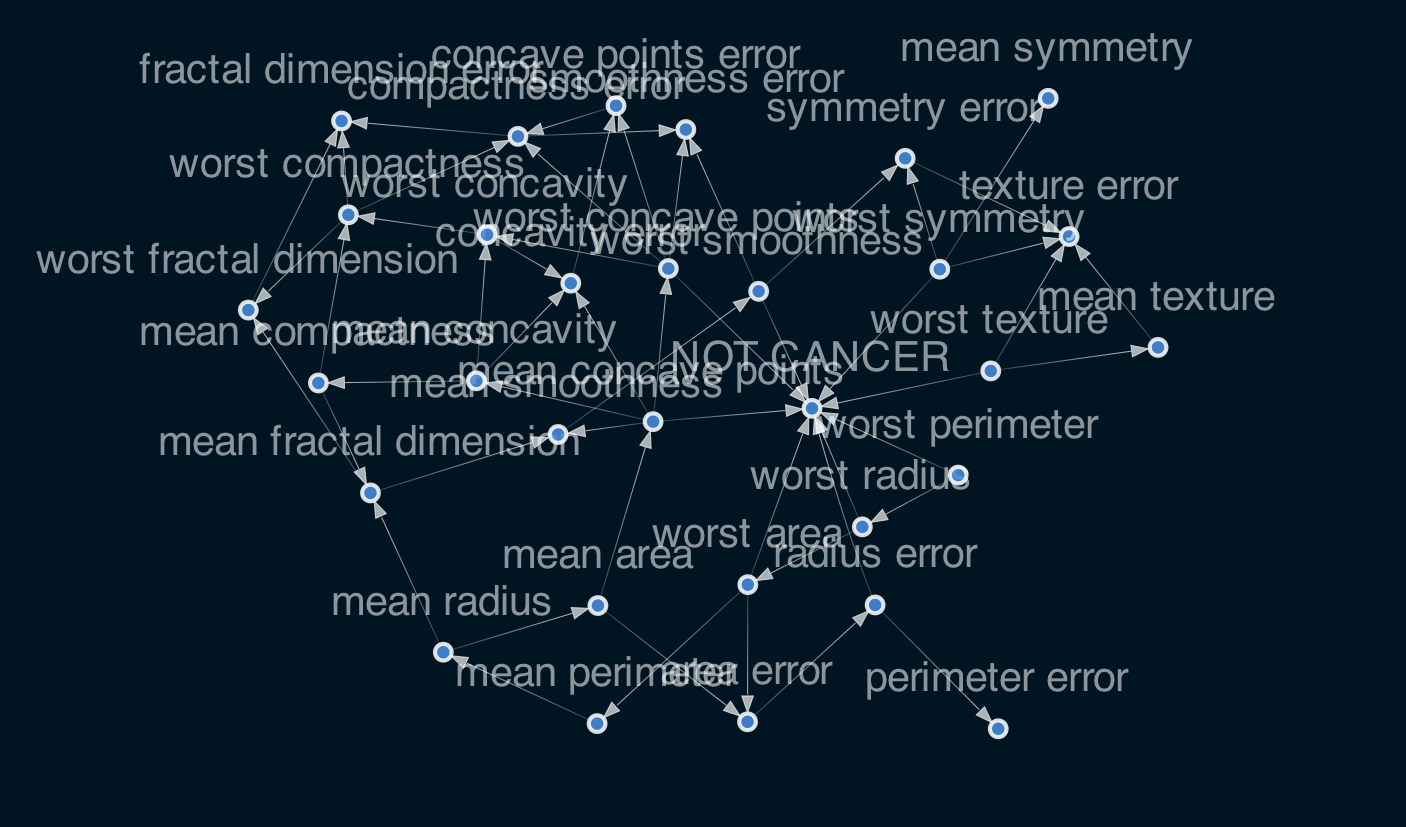

In [12]:

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure.pytorch import DAGClassifier
clf = DAGClassifier(
                alpha=0.1,
                beta=0.5,
                hidden_layer_units=[0],
                fit_intercept=True,
                standardize=True
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="NOT CANCER")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)

### Categorical Classifier
#### The Data: Iris

In [13]:
from sklearn.datasets import load_iris
print(load_iris(return_X_y=False)["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

MEAN Score: 0.913
MEAN EFFECT DIRECTIONAL CLASS 0:
sepal width (cm)     0.455312
sepal length (cm)   -0.449905
petal width (cm)    -0.677298
petal length (cm)   -0.744438
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 1:
sepal length (cm)    0.002599
petal length (cm)    0.000342
petal width (cm)    -0.001675
sepal width (cm)    -0.356841
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 2:
petal width (cm)     0.873676
petal length (cm)    0.628711
sepal length (cm)    0.272615
sepal width (cm)    -0.000025
dtype: float64


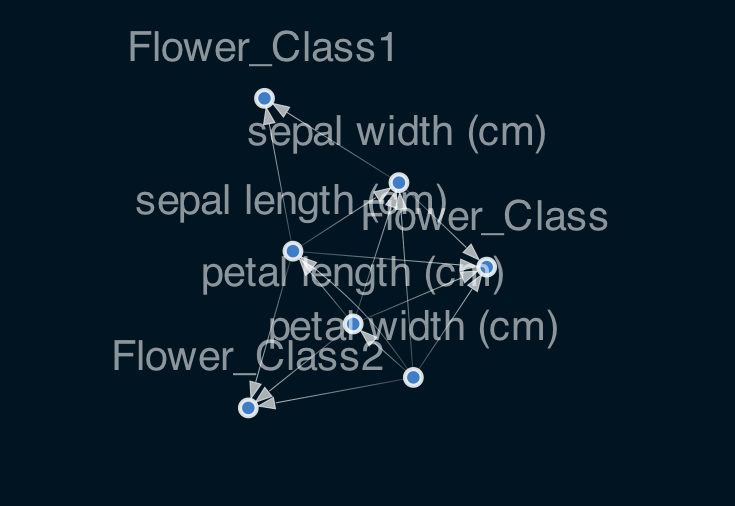

In [14]:

from sklearn.datasets import load_breast_cancer
data = load_iris()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure.pytorch import DAGClassifier
clf = DAGClassifier(
                alpha=0.1,
                beta=0.5,
                hidden_layer_units=[0],
                fit_intercept=True,
                standardize=True
                 )

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="Flower_Class")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)